Tasklist for this week's excercise:

- [x] Load data to DB
- [x] Read data from DB in iteration
- [x] Check how much duplicate rows are present and remove the duplicates
- [x] Get tags count and plot to find out mode frequent tags
- [x] Get # of tags per question count 
- [ ] Preprocessing Body: Remove html tags, spl cahrs, , lowercase all, stemming and lemmitization
- [ ] Define vector
- [ ] Define labels
- [ ] Splitting the data
- [ ] Define ML models
- [ ] Train, Test

Download the data from [here](https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction)

### Load the data from excel to sqlite database

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

### 1. Load the data from excel to sqlite database

In [2]:
%%time

chunksize = 180000
if not os.path.isfile("data/train.db"):
    disk_engine = create_engine("sqlite:///data/train.db")
    index_start = 1
    j=0
    for df in pd.read_csv('data/Train.csv', chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index+= index_start
        j+=1
        print(f"{j*chunksize} rows")
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

CPU times: user 23 µs, sys: 9 µs, total: 32 µs
Wall time: 35 µs


In [37]:
def execute(query, apply_chunk=True, delete=False):
    with sqlite3.connect('data/train.db') as con:
        if apply_chunk and not delete:
            data = pd.read_sql(query, con, chunksize= chunksize)
        elif delete == True:
            data = con.execute(query)
        else:
            data = pd.read_sql(query, con)
    return data    

#### 1.1 Get row count from db

In [40]:
def get_row_count():
    num_rows = execute('SELECT COUNT(*) FROM data')
    count_rows = 0
    for i in num_rows:
        count_rows +=i.values
    return count_rows

In [41]:
%%time

print(int(get_row_count()))

4206314
CPU times: user 126 ms, sys: 262 ms, total: 388 ms
Wall time: 1.66 s


### 2. Preprocessing the data

#### 2.1 Capturing the duplicate row counts

In [103]:
def print_dup_rows_cnt():
    df = execute('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags HAVING cnt_dup > 1')
    count_dict = {}
    for i in df:
        new_dict = dict(i.cnt_dup.value_counts())
        for k,v in new_dict.items():
            if k not in count_dict:
                count_dict[k] = v
            else:
                count_dict[k] += v
    dup_total = sum({k:v for k,v in count_dict.items() if k != 1}.values())
    print(f"{dup_total/int(count_rows) * 100} % of dataset has duplicates.")

In [104]:
%%time

print_dup_rows_cnt()

0.0 % of dataset has duplicates.
CPU times: user 11.2 s, sys: 11.4 s, total: 22.6 s
Wall time: 37.1 s


#### 2.2 Removing duplicate rows

In [38]:
%%time

execute('DELETE FROM data WHERE ID NOT IN (SELECT MAX(ID) FROM data GROUP BY Title, Body, Tags)', delete=True)

CPU times: user 40.9 s, sys: 55.9 s, total: 1min 36s
Wall time: 3min 1s


In [48]:
%%time

print(int(get_row_count()))

4206314
CPU times: user 122 ms, sys: 226 ms, total: 348 ms
Wall time: 1.46 s


In [47]:
%%time

print_dup_rows_cnt()

0.0 % of dataset has duplicates.
CPU times: user 11.2 s, sys: 11.2 s, total: 22.4 s
Wall time: 37.2 s


### 3. Exploring the data 

#### 3.1 Getting the tags frequency

In [76]:
%%time


df = execute('SELECT Tags FROM data')
tags_dict = {}
for i in df:
    tag_list_list = i.Tags.apply(lambda x: x.split(' ') if x else []).values
    for tag_list in tag_list_list:
        for tag_name in tag_list:
            if tag_name not in tags_dict:
                tags_dict[tag_name] = 1
            else:
                tags_dict[tag_name]+=1

CPU times: user 12.6 s, sys: 4.49 s, total: 17.1 s
Wall time: 27.3 s


In [77]:
tags_dict

{'php': 284103,
 'image-processing': 7099,
 'file-upload': 6807,
 'upload': 4281,
 'mime-types': 966,
 'firefox': 14066,
 'r': 20096,
 'matlab': 13532,
 'machine-learning': 2141,
 'c#': 331505,
 'url': 10870,
 'encoding': 5706,
 'core-plot': 775,
 'asp.net': 125651,
 'windows-phone-7': 12204,
 '.net': 114087,
 'obfuscation': 910,
 'reflector': 143,
 'url-routing': 1291,
 'conventions': 375,
 'haskell': 8138,
 'html': 120237,
 'semantic': 609,
 'line-breaks': 480,
 'c++': 143936,
 'gcc': 7671,
 'stl': 4270,
 'bounds-checker': 16,
 'css': 93745,
 'jquery-ui': 15531,
 'asp.net-mvc-4': 5483,
 'bundle': 1142,
 'asp.net-optimization': 67,
 'entity-framework-4': 4836,
 'visual-studio-2008': 10679,
 '.net-2.0': 1661,
 'netcat': 232,
 'java': 299414,
 'python': 134137,
 'strong-typing': 154,
 'jquery': 221533,
 'json': 31874,
 'attributes': 3482,
 'each': 730,
 'mfc': 3887,
 'midi': 483,
 'comm': 44,
 'android': 235436,
 'android-ndk': 2901,
 'android-source': 341,
 'asp.net-mvc': 41894,
 'desi

In [78]:
tags_to_idx = {k:i for i,(k,v) in enumerate(tags_dict.items())}
tags_to_idx

{'php': 0,
 'image-processing': 1,
 'file-upload': 2,
 'upload': 3,
 'mime-types': 4,
 'firefox': 5,
 'r': 6,
 'matlab': 7,
 'machine-learning': 8,
 'c#': 9,
 'url': 10,
 'encoding': 11,
 'core-plot': 12,
 'asp.net': 13,
 'windows-phone-7': 14,
 '.net': 15,
 'obfuscation': 16,
 'reflector': 17,
 'url-routing': 18,
 'conventions': 19,
 'haskell': 20,
 'html': 21,
 'semantic': 22,
 'line-breaks': 23,
 'c++': 24,
 'gcc': 25,
 'stl': 26,
 'bounds-checker': 27,
 'css': 28,
 'jquery-ui': 29,
 'asp.net-mvc-4': 30,
 'bundle': 31,
 'asp.net-optimization': 32,
 'entity-framework-4': 33,
 'visual-studio-2008': 34,
 '.net-2.0': 35,
 'netcat': 36,
 'java': 37,
 'python': 38,
 'strong-typing': 39,
 'jquery': 40,
 'json': 41,
 'attributes': 42,
 'each': 43,
 'mfc': 44,
 'midi': 45,
 'comm': 46,
 'android': 47,
 'android-ndk': 48,
 'android-source': 49,
 'asp.net-mvc': 50,
 'design': 51,
 'modelstate': 52,
 'service-layer': 53,
 'unit-testing': 54,
 'testing': 55,
 'theory': 56,
 'oracle': 57,
 'repor

In [80]:
df_tag_cnt = pd.DataFrame(columns=['tags', 'counts'])
df_tag_cnt.tags = tags_dict.keys()
df_tag_cnt.counts = tags_dict.values()

In [94]:
df_tag_cnt

,tags,counts
0,php,284103
1,image-processing,7099
2,file-upload,6807
3,upload,4281
4,mime-types,966
...,...,...
42043,promises,1
42044,onlyamsmath,1
42045,proficiency,1
42046,syntax-object,1


In [84]:
tag_df_sorted = df_tag_cnt.sort_values(['counts'], ascending=False)
tag_counts = tag_df_sorted['counts'].values

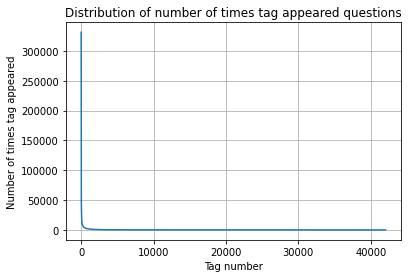

In [99]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

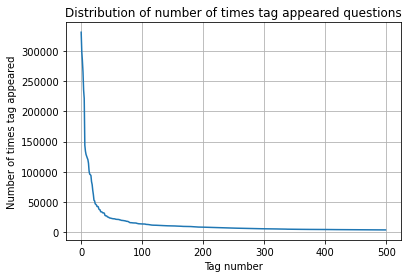

In [100]:
plt.plot(tag_counts[0:500])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

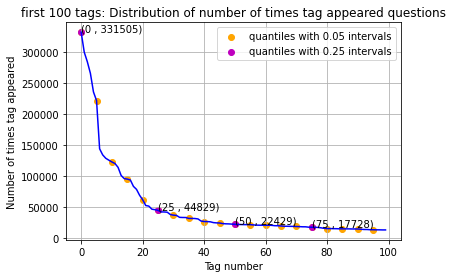

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [102]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(text="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [95]:
df_tag_cnt.sort_values(['counts'], ascending=False)

,tags,counts
9,c#,331505
37,java,299414
0,php,284103
69,javascript,265423
47,android,235436
...,...,...
39610,smartdraw,1
36914,zipinstaller,1
39612,old-mac,1
36913,nirsoft,1


#### 3.2 Getting the tags per question count

In [114]:
%%time


df = execute('SELECT Tags FROM data')
tags_cnt_per_q = []
for i in df:
    tag_list_list = i.Tags.apply(lambda x: x.split(' ') if x else []).values
    for tag_list in tag_list_list:
        tags_cnt_per_q.append(len(tag_list))

CPU times: user 10.2 s, sys: 3.88 s, total: 14.1 s
Wall time: 22.6 s


In [118]:
len(tags_cnt_per_q)

4206314

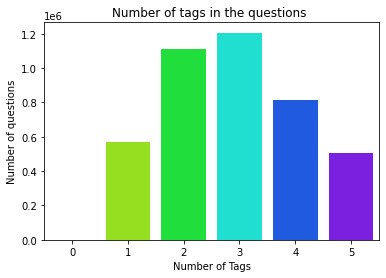

In [119]:
sns.countplot(x=tags_cnt_per_q ,palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()